In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime

plt.rc('font', family='malgun gothic')
plt.rc('axes' , unicode_minus = False)

### **거리두기 기간 때 좌석의 오픈 여부를 찾아내자**

- ##### 개별 좌석 별 예매 된 횟수등을 보려 할 때 거리두기로 인해서 오픈되지 않은 좌석들이 있을 것이다.
    - 정확한 좌석의 선호도를 알기 위해 좌석이 구매 가능한  경우와 구매가 불가능한 경우(거리두기 기간 때는 예매 된 좌석 양 옆으로는 예매가 불가능했다)를 맵핑하자

In [2]:
df = pd.read_csv("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/키워드_검색량_추가_클래식_데이터.csv", low_memory = False)

In [3]:
example_df = df[df['전체공연시간'] == '2021-12-18 17:00:00']

In [4]:
def covid_open_extract(data):
    
    floors = ['1층','2층','3층','합창석']

    end_data_list = []

    for floor in floors:
        '''
        조건에 따라서 층, 블록, 세부 좌석 (넘버) 별로 컨디셔닝 된 데이터 테이블을 만드는 반복문
        '''
        floor_cond = data['층'] == floor 

        blocks = sorted(data[floor_cond]['블록'].unique())
        
        for block in blocks:
            
            block_cond = data['블록'] == block
            
            columns = sorted(data[(floor_cond) & (block_cond)]['열'].unique())
            
            for column in columns:
                
                column_cond = data['열'] == column
                
                cond_data = data[(floor_cond) & (block_cond) & (column_cond)] # 몇층, 몇 블록, 몇 열의 일직선상의 좌석이 담긴 데이터프레임
                
                cond_data = cond_data.sort_values(by  = '넘버') # 좌석을 넘버 별로 오름차순 정렬
                purchase_list = list(cond_data['예매여부']) # 좌석 순 별로 구매 여부를 담은 리스트
                open_list = [] # 오픈 여부를 담을 리스트

                for i in range(len(purchase_list)):
                    
                    if purchase_list[i] == 1: # 만약 구매가 된 자리라면
                        open_list.append(1) # 좌석이 오픈된 경우이기에 구매가 되었음으로 오픈 되었음으로 체크
                    
                    else: # 만약 구매가 안되었을 경우에는 양 옆 좌석의 구매 여부를 확인해보아야 함
                        
                        if i == 0: # 만약 첫 좌석일 경우에는 양 옆이 아닌 오른쪽 좌석을 확인해봐야함 
                            if purchase_list[i+1] == 1: # 옆 좌석이 구매가 된 경우에는
                                open_list.append(0) # 오픈이 안되었을테니 0
                            else:
                                open_list.append(1) # 옆 좌석이 구매가 안되어있다면 오픈이 된 좌석이였음
                        elif i == len(purchase_list) - 1: #만약 끝 좌석일 때에도 양 옆이 아닌 왼쪽 좌석만 살펴보면 됨 
                            if purchase_list[i-1] == 1: 
                                open_list.append(0) 
                            else:
                                open_list.append(1)
                        else: # 맨 끝 좌석이 아닌 경우엔 양 옆을 살펴보아야 함 
                            
                            if purchase_list[i-1] +  purchase_list[i+1] > 0: # 양 옆 좌석 중 하나라도 구매가 되어있다면
                                open_list.append(0)
                            else:
                                open_list.append(1)
                                
                cond_data['좌석 오픈 여부'] = open_list
                end_data_list.append(cond_data)
                
    result =  pd.concat(end_data_list) # 블록, 좌석, 열 별로 오픈 리스트가 생성된 데이터프레임을 하나로 합침
    
    return result

In [5]:
example_result = covid_open_extract(example_df) # 테스트해보자

Text(0.5, 1.1, '구매 여부와 좌석 오픈 여부 비교 그래프')

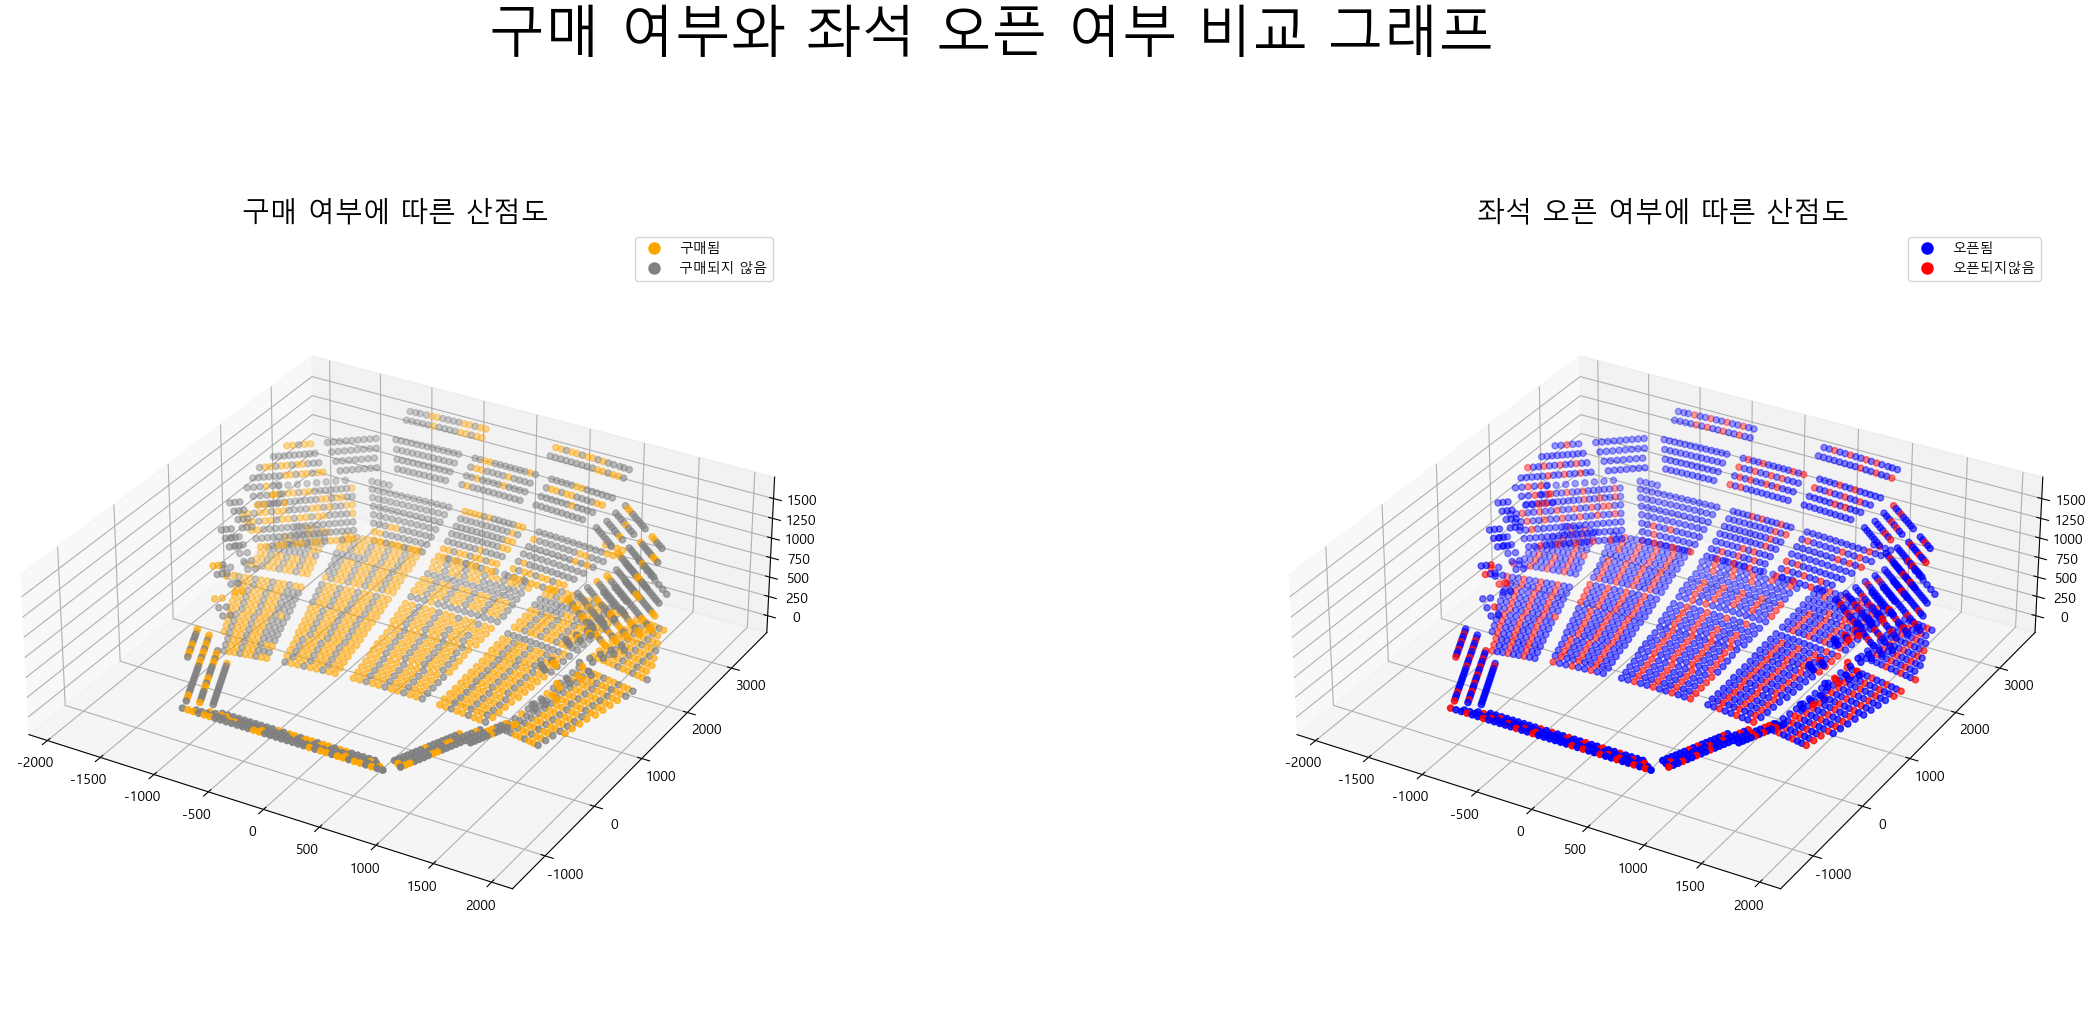

In [6]:
fig,ax = plt.subplots(subplot_kw = {'projection': '3d'}, figsize = (30,10), ncols = 2)

ax[0].set_box_aspect([3,3,1])
ax[1].set_box_aspect([3,3,1])

open_list = example_result['좌석 오픈 여부']
purchase_list = example_result['예매여부']

open_cmap = ['blue' if o == 1  else 'red' for o in open_list]
purchase_cmap = ['orange' if p == 1  else 'grey' for p in purchase_list]


ax[0].scatter3D(
    data = example_result,
    xs = 'X',
    ys = 'Y',
    zs = 'Z',
    color = purchase_cmap
)

ax[1].scatter3D(
    data = example_result,
    xs = 'X',
    ys = 'Y',
    zs = 'Z',
    color = open_cmap
)

purchase_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='구매됨'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='구매되지 않음')]

open_handles = [Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'blue', markersize = 10, label = '오픈됨'),
                Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'red', markersize = 10, label = '오픈되지않음')]

# 범례 생성
ax[0].legend(handles= purchase_handles, loc='best')
ax[1].legend(handles = open_handles, loc = 'best')

ax[0].set_title('구매 여부에 따른 산점도', fontsize = 20)
ax[1].set_title('좌석 오픈 여부에 따른 산점도', fontsize = 20)

fig.suptitle('구매 여부와 좌석 오픈 여부 비교 그래프', fontsize = 40, y = 1.1)

잘 작동 되는 것을 확인했다. 

확인했으니 전체 데이터에 대해서 적용시켜보도록 하자

거리두기 시행한 기간에는 해당 내용처럼 좌석의 오픈 여부를 평가하고

거리두기를 시행하지 않은 기간에는 모든 좌석이 오픈 되었다고 측정하자

### **거리두기 기간 : 2020-05-05 20:00:00 ~ 2022-06-21 19:30:00**

In [7]:
unique_performance = sorted(df['전체공연시간'].unique()) # 각 공연 별로 


df_list = []

for perf_time in unique_performance:
    
    cond = df['전체공연시간'] == perf_time 
    cond_df = df[cond].copy()
    
    if perf_time < '2020-05-05 20:00:00' or perf_time > '2022-06-21 19:30:00': # 코로나 거리두기 기간이 아닌 경우 
        cond_df['좌석 오픈 여부'] = 1 # 모든 좌석의 오픈 여부를 1로 맵핑 
        df_list.append(cond_df)
    else:
        df_list.append(covid_open_extract(cond_df)) # 코로나 거리두기 기간일 때는 위에서 설명한 함수 호출

In [8]:
result_df = pd.concat(df_list)

display(result_df.head())
print(result_df.shape)

,seat,층,블록,열,넘버,X,Y,Z,대칭점,좌우시야각,...,intermission,member_yn,공연연도,공연월,공연일,공연연월,전체공연시간,전체거래시간,누적검색량,좌석 오픈 여부
0,1층 A블록1열 1,1층,A블록,1,1,1451,542,-93,1층 E블록1열 9,15,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
1,1층 A블록1열 2,1층,A블록,1,2,1406,555,-93,1층 E블록1열 8,16,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
2,1층 A블록1열 3,1층,A블록,1,3,1361,568,-93,1층 E블록1열 7,18,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
3,1층 A블록1열 4,1층,A블록,1,4,1315,580,-93,1층 E블록1열 6,21,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
4,1층 A블록1열 5,1층,A블록,1,5,1270,591,-93,1층 E블록1열 5,23,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1


(405810, 42)


In [9]:
file_path = "C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/"  # 파일저장
result_df.to_csv(file_path + '오픈여부_추가_클래식_데이터.csv', index = False)

In [ ]:
멈춰 ! 멈추기 위한 코드

이 밑에는 마지막 테이블 생성으로 남겨둬야해 

* 데이터 테이블 생성 (공연 별, 좌석 별)

In [66]:
reservation_grouping = result_df.groupby('전체공연시간').agg({'좌석 오픈 여부' : np.sum, '예매여부' : np.sum, 'price':np.mean}).reset_index()
reservation_grouping['공연 예매율'] = reservation_grouping['예매여부'] / reservation_grouping['좌석 오픈 여부'] # 공연 별 예매율 계산 

reservation_grouping = reservation_grouping.rename(columns = {'price': '공연 별 평균 가격'})

reservation_grouping.head()

,전체공연시간,좌석 오픈 여부,예매여부,공연 별 평균 가격,공연 예매율
0,2018-11-25 17:00:00,2505,1537,1640.858816,0.613573
1,2018-12-08 17:00:00,2505,2159,1182.028717,0.861876
2,2019-01-11 20:00:00,2505,1425,44413.333333,0.568862
3,2019-02-05 20:00:00,2505,2149,938.110749,0.857884
4,2019-02-16 17:00:00,2505,1166,6556.603774,0.465469


In [67]:
# 공연별 예매율 테이블 생성

cols = ['play_date', 'play_st_time','pre_open_date','open_date', 'running_time', 'intermission','전체공연시간','누적검색량'] # 합병해주자 


pre_table = pd.merge(reservation_grouping,result_df[cols], on = '전체공연시간', how = 'left').drop_duplicates() # merge 후 중복을 제거 

reservation_table = pre_table.reset_index(drop = True) # index 초기화 

In [68]:
# 공연별 요약 테이블에서 EDA 할 때 용이하도록 날짜도 포함해서 만들도록 하자 

reservation_table['연도'] = pd.to_datetime(reservation_grouping['전체공연시간']).map(lambda x: x.year)
reservation_table['월'] = pd.to_datetime(reservation_grouping['전체공연시간']).map(lambda x: x.month)
reservation_table['연 월'] = pd.to_datetime(reservation_table['연도'].astype(str) + '-' + reservation_table['월'].astype(str)) 
reservation_table['일'] = pd.to_datetime(reservation_grouping['전체공연시간']).map(lambda x: x.day)
reservation_table['시간'] = pd.to_datetime(reservation_grouping['전체공연시간']).map(lambda x: x.hour)
reservation_table['요일'] =  pd.to_datetime(reservation_table['play_date']).map(lambda x: x.weekday())  # 월요일 0 , 화요일 1 .... 일요일 6 으로 맵핑되도록 변경

In [69]:
display(reservation_table.head())
print(reservation_table.shape)

,전체공연시간,좌석 오픈 여부,예매여부,공연 별 평균 가격,공연 예매율,play_date,play_st_time,pre_open_date,open_date,running_time,intermission,누적검색량,연도,월,연 월,일,시간,요일
0,2018-11-25 17:00:00,2505,1537,1640.858816,0.613573,2018-11-25,17:00:00,2018-10-28,2018-10-29,120,15,1000,2018,11,2018-11-01,25,17,6
1,2018-12-08 17:00:00,2505,2159,1182.028717,0.861876,2018-12-08,17:00:00,NaN,2018-10-29,140,20,980,2018,12,2018-12-01,8,17,5
2,2019-01-11 20:00:00,2505,1425,44413.333333,0.568862,2019-01-11,20:00:00,2018-12-10,2018-12-10,105,15,1180,2019,1,2019-01-01,11,20,4
3,2019-02-05 20:00:00,2505,2149,938.110749,0.857884,2019-02-05,20:00:00,NaN,2018-12-22,120,20,1020,2019,2,2019-02-01,5,20,1
4,2019-02-16 17:00:00,2505,1166,6556.603774,0.465469,2019-02-16,17:00:00,NaN,2018-12-30,130,20,1220,2019,2,2019-02-01,16,17,5


(162, 18)


In [70]:
seat_grouping = result_df.groupby('seat').agg({'예매여부': np.sum, '좌석 오픈 여부': np.sum, 'price':np.mean, '거래까지걸린시간_시간':np.mean, '거래까지걸린시간_등수' : np.mean}).reset_index()
seat_grouping['좌석 예매율'] = seat_grouping['예매여부'] / seat_grouping['좌석 오픈 여부']
seat_grouping = seat_grouping.rename(columns = {'price': '좌석 별 평균 가격'})


seat_grouping.head()

,seat,예매여부,좌석 오픈 여부,좌석 별 평균 가격,거래까지걸린시간_시간,거래까지걸린시간_등수,좌석 예매율
0,1층 A블록10열 1,70,153,20057.142857,828.698095,1105.378910,0.457516
1,1층 A블록10열 10,96,155,26770.833333,693.585069,810.635850,0.619355
2,1층 A블록10열 11,84,143,28119.047619,730.825595,793.470474,0.587413
3,1층 A블록10열 2,77,152,21025.974026,765.852814,1006.822059,0.506579
4,1층 A블록10열 3,73,144,19520.547945,788.947945,956.426186,0.506944


In [71]:
cols = ['seat','층', '블록','열','넘버','X','Y','Z','대칭점','무대_밑_좌우시야각','무대_위_좌우시야각','무대가_보이는_면적']

pre_table = pd.merge(seat_grouping,result_df[cols], on = 'seat', how = 'left').drop_duplicates()

seat_table = pre_table.reset_index(drop = True)

display(seat_table.head())
print(seat_table.shape)

,seat,예매여부,좌석 오픈 여부,좌석 별 평균 가격,거래까지걸린시간_시간,거래까지걸린시간_등수,좌석 예매율,층,블록,열,넘버,X,Y,Z,대칭점,무대_밑_좌우시야각,무대_위_좌우시야각,무대가_보이는_면적
0,1층 A블록10열 1,70,153,20057.142857,828.698095,1105.378910,0.457516,1층,A블록,10,1,1747,1347,69,1층 E블록10열 11,17,30,1798
1,1층 A블록10열 10,96,155,26770.833333,693.585069,810.635850,0.619355,1층,A블록,10,10,1296,1463,69,1층 E블록10열 2,20,43,1945
2,1층 A블록10열 11,84,143,28119.047619,730.825595,793.470474,0.587413,1층,A블록,10,11,1246,1473,69,1층 E블록10열 1,20,44,1972
3,1층 A블록10열 2,77,152,21025.974026,765.852814,1006.822059,0.506579,1층,A블록,10,2,1698,1361,69,1층 E블록10열 10,17,31,1808
4,1층 A블록10열 3,73,144,19520.547945,788.947945,956.426186,0.506944,1층,A블록,10,3,1649,1375,69,1층 E블록10열 9,18,33,1818


(2505, 18)


In [72]:
file_path = 'C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/'

reservation_table.to_csv(file_path + 'reservation_table.csv',index = False)
seat_table.to_csv(file_path + 'seat_table.csv', index = False)